## Passing network

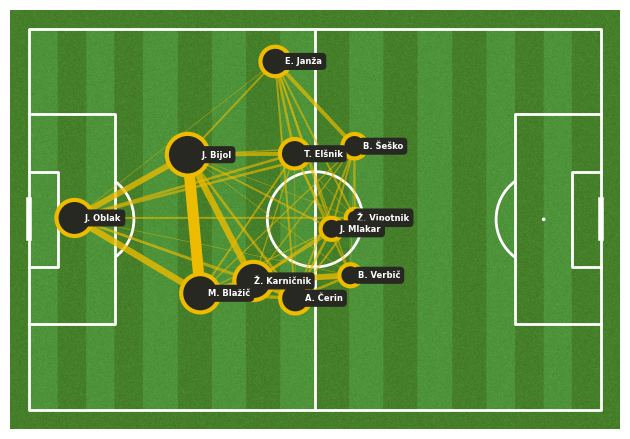

In [50]:
import pandas as pd
import numpy as np

from mplsoccer import Pitch, Sbopen
from mplsoccer import VerticalPitch,Pitch
from mplsoccer import Pitch

pitch_length = 120
pitch_width = 80

data = pd.read_csv(f"./results/wyscout/5414302_df_events.csv")

data = data[['location.x', 'location.y', 'pass.endLocation.x', 'pass.endLocation.y', "player.name", "pass.recipient.name","team.name","minute",'player.id']]

df_merged = data.rename(columns={
'location.x':'x',
'location.y':'y',
'pass.endLocation.x':'end_x',
'pass.endLocation.y':'end_y',
"player.name":"player_name",
"pass.recipient.name":"pass_recipient_name",
"team.name":"team_name",
"minute":"minute",
"player.id":'player_id'
})


df_home_pass = df_merged[df_merged.team_name != 'Denmark']

# Check player play time
home_player_df = df_merged[df_merged.team_name != 'Denmark'].groupby('player_name').agg({'minute': [min, max]}).reset_index()
home_player_df = pd.concat([home_player_df['player_name'], home_player_df['minute']], axis=1)
home_player_df['minutes_played'] = home_player_df['max'] - home_player_df['min']
home_player_df = home_player_df.sort_values('minutes_played', ascending=False)

home_player_name = home_player_df.player_name[:11].tolist()
df_home_pass = df_home_pass[df_home_pass.player_name.isin(home_player_name)]
df_home_pass = df_home_pass[df_home_pass.pass_recipient_name.isin(home_player_name)]

scatter_df = pd.DataFrame()
for i, name in enumerate(df_home_pass["player_name"].unique()):
    passx = df_home_pass.loc[df_home_pass["player_name"] == name]["x"].to_numpy()
    recx = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_home_pass.loc[df_home_pass["player_name"] == name]["y"].to_numpy()
    recy = df_home_pass.loc[df_home_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    #calculate number of passes
    scatter_df.at[i, "no"] = df_home_pass.loc[df_home_pass["player_name"] == name].count().iloc[0]
    
#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 900)

#Calculate edge width
df_home_pass["pair_key"] = df_home_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_home_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold
lines_df = lines_df[lines_df['pass_count']> 0]


import matplotlib.pyplot as plt
pitch = Pitch(pitch_color='grass', line_color='white', stripe=True)

fig, ax = pitch.draw()

pitch.scatter(scatter_df.x / 100 * pitch_length, scatter_df.y / 100 * pitch_width, s=scatter_df.marker_size, color='#272822', edgecolors='#EDBB00', linewidth=3, alpha=1, ax=ax, zorder = 3)

for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x/100 * pitch_length +6, row.y/100 * pitch_width), c='white', va='center',
                   ha='center', size=6, weight = "bold", ax=ax, zorder = 4, 
                   bbox=dict(facecolor='#272822', alpha=1, edgecolor='#272822', boxstyle='round,pad=0.4'))
    

for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'] / 100 * pitch_length
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'] / 100 * pitch_width
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'] / 100 * pitch_length
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'] / 100 * pitch_width
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 8)
        # adjust the alpha of the lines based on number of passes and set minimum alpha for a fewer pass
        alpha = 0.5 * num_passes / lines_df['pass_count'].max() + 0.5
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="#EDBB00", ax = ax)

plt.savefig('plots/passing_network.png', dpi=400)
plt.show()

In [58]:
import pandas as pd
import json
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch, Pitch

def preprocess_team_pass_data(df_events, team_name):
    df_passes = df_events[df_events['type.primary'] == 'pass']
    df_accurate_passes = df_passes[df_passes['pass.accurate'] == True]
    ap_team = df_accurate_passes[df_accurate_passes['team.name'] == team_name]
    filtered_passes = ap_team[['player.name', 'pass.recipient.name', 'location.x', 'location.y']].copy()
    average_positions = ap_team.groupby('player.name').agg({'location.x': 'mean', 'location.y': 'mean'}).reset_index()
    return filtered_passes, average_positions

def create_weighted_graph(df):
    G = nx.DiGraph()
    unique_players = set(df['player.name'])
    unique_recipients = set(df['pass.recipient.name'])

    for index, row in df.iterrows():
        player = row['player.name']
        recipient = row['pass.recipient.name']

        if player is None or recipient is None:
            continue

        if player not in unique_recipients or recipient not in unique_players:
            continue

        if G.has_edge(player, recipient):
            G[player][recipient]['weight'] += 1
        else:
            G.add_edge(player, recipient, weight=1)

    return G

def calculate_top_players(G):
    centrality_measures = {
        "Degree Centrality": nx.degree_centrality(G),
        "Betweenness Centrality": nx.betweenness_centrality(G),
        "Closeness Centrality": nx.closeness_centrality(G),
        "Eigenvector Centrality": nx.eigenvector_centrality(G),
        "PageRank Centrality": nx.pagerank(G) 
    }

    top_players = {}
    # Loop through each centrality measure
    for measure, centrality in centrality_measures.items():
        sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
        top_players[measure] = [f"{player}: {centrality_value:.4f}" for player, centrality_value in sorted_centrality[:3]]

    return top_players


#example usage
df_events = pd.read_csv(f"./results/wyscout/5414302_df_events.csv")
filtered_passes_g, average_positions_g = preprocess_team_pass_data(df_events, 'Slovenia')
G = create_weighted_graph(filtered_passes_g)
values = calculate_top_players(G)

for val in values:
    print(f'#### {val}')
    print(values[val])


{'Degree Centrality': ['A. Čerin: 1.5333', 'J. Bijol: 1.4667', 'Ž. Karničnik: 1.3333'], 'Betweenness Centrality': ['V. Drkušić: 0.1163', 'A. Čerin: 0.0945', 'Ž. Karničnik: 0.0827'], 'Closeness Centrality': ['J. Bijol: 0.7500', 'A. Čerin: 0.7500', 'B. Šeško: 0.7500'], 'Eigenvector Centrality': ['B. Šeško: 0.3691', 'A. Čerin: 0.3684', 'Ž. Karničnik: 0.3122'], 'PageRank Centrality': ['Ž. Karničnik: 0.1125', 'J. Bijol: 0.0986', 'A. Čerin: 0.0949']}
#### Degree Centrality
['A. Čerin: 1.5333', 'J. Bijol: 1.4667', 'Ž. Karničnik: 1.3333']
#### Betweenness Centrality
['V. Drkušić: 0.1163', 'A. Čerin: 0.0945', 'Ž. Karničnik: 0.0827']
#### Closeness Centrality
['J. Bijol: 0.7500', 'A. Čerin: 0.7500', 'B. Šeško: 0.7500']
#### Eigenvector Centrality
['B. Šeško: 0.3691', 'A. Čerin: 0.3684', 'Ž. Karničnik: 0.3122']
#### PageRank Centrality
['Ž. Karničnik: 0.1125', 'J. Bijol: 0.0986', 'A. Čerin: 0.0949']
